# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
| ------------- |-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants with higher education level
4. Properties in urban areas with high growth perspectives

Do more brainstorming and create some hypotheses of your own. Remember that the data might not be sufficient to test all of these, but forming these enables a better understanding of the problem.

## 2. Data Exploration
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

In [772]:
# common packages
import pandas as pd
import numpy as np

# setup specific packages
from pathlib import Path

# exploratory packages
from matplotlib import pyplot as plt
from scipy.stats import shapiro, skew

In [773]:
data_path = Path('./assets')

df = pd.read_csv(data_path / 'loan_data.csv') 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Separate Target Variable

One of the key challenges in any data set are missing values. Lets start by checking which columns contain missing values.

In [774]:
# proportion of data that is null or missing
print(df.isnull().sum()[df.isnull().sum() / df.shape[0] !=0 ])
print(df.shape)

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64
(614, 13)


In [775]:
# drop rows where there are missing values for categorical
df.dropna(
    axis=0,
    subset=['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History'],
    inplace=True)

df.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           19
Loan_Amount_Term     12
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [776]:
if 2:
    print('hi')

hi


In [777]:
# drop target and loan_id features
x = df.drop(columns=['Loan_Status', 'Loan_ID'])
y = df['Loan_Status']

### Separate Numerical and Categorical

In [778]:
def select_nums(df, drop=None, add=None):
    if drop:
        dfnums = df[df.columns[df.dtypes != object]].drop(columns=drop)
    if add:
        dfnums = pd.concat([df[df.columns[(df.dtypes != object)]], df[[add]]], axis=1)
    return dfnums

def select_cats(df, drop=None, add=None):
    if drop:
        dfcats = df[df.columns[df.dtypes == object]].drop(columns=drop)
    if add:
        dfcats = pd.concat([df[df.columns[(df.dtypes == object)]], df[add]], axis=1)
    return dfcats

In [779]:
xnums = select_nums(x, drop=['Loan_Amount_Term', 'Credit_History'])
xcats = select_cats(x, drop=None, add=['Loan_Amount_Term', 'Credit_History'])
# xnums = x[x.columns[x.dtypes != object]].drop(columns=['Loan_Amount_Term', 'Credit_History'])
# xcats = pd.concat([x[x.columns[~(x.dtypes != object)]], x[['Loan_Amount_Term', 'Credit_History']]], axis=1)

In [780]:
print(xnums.columns)
print(xcats.columns)

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], dtype='object')
Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'Loan_Amount_Term', 'Credit_History'],
      dtype='object')


Look at some basic statistics for numerical variables.

In [781]:
xnums.describe().astype(int)

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,511,511,492
mean,5308,1561,144
std,5561,2559,79
min,150,0,9
25%,2885,0,100
50%,3858,1086,128
75%,5820,2253,170
max,81000,33837,600


1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise)

In [782]:
print('Applicants whose credit history does not meet guidelines:',(xcats['Credit_History'] == 0).sum())

Applicants whose credit history does not meet guidelines: 80


2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`?

In [783]:
# grab the shapiro stats for normal distributions
tstat = {}
pval = {}

for i,col in enumerate(xnums.columns):
    t,p = shapiro(xnums[col])
    
    tstat[col] = t
    pval[col] = p
    
print(tstat)
print(pval)

{'ApplicantIncome': 0.4949631690979004, 'CoapplicantIncome': 0.5591318607330322, 'LoanAmount': nan}
{'ApplicantIncome': 1.252874939885011e-35, 'CoapplicantIncome': 7.037506517510489e-34, 'LoanAmount': 1.0}


> According to pval, `LoanAmount` follows a normal distribution, while the others do not.

3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature.



In [784]:
print(xnums['LoanAmount'].skew())
print(xnums['ApplicantIncome'].skew())
print(xnums['CoapplicantIncome'].skew())

2.387942560875531
6.944482761188726
5.93008656626681


Let's discuss nominal (categorical) variable. Look at the number of unique values in each of them.

In [785]:
for col in xcats.columns:
    print(col, xcats[col].unique())

Gender ['Male' 'Female']
Married ['No' 'Yes']
Dependents ['0' '1' '2' '3+']
Education ['Graduate' 'Not Graduate']
Self_Employed ['No' 'Yes']
Property_Area ['Urban' 'Rural' 'Semiurban']
Loan_Amount_Term [360. 120.  nan 180.  60. 300. 480. 240.  36.  84.]
Credit_History [1. 0.]


Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

In [786]:
for col in xcats.columns:
    print(col, xcats[col].value_counts().to_list())

Gender [420, 91]
Married [331, 180]
Dependents [294, 88, 85, 44]
Education [401, 110]
Self_Employed [441, 70]
Property_Area [197, 165, 149]
Loan_Amount_Term [428, 38, 12, 9, 3, 3, 2, 2, 2]
Credit_History [431, 80]


### Distribution analysis

Study distribution of various variables. Plot the histogram of ApplicantIncome, try different number of bins.



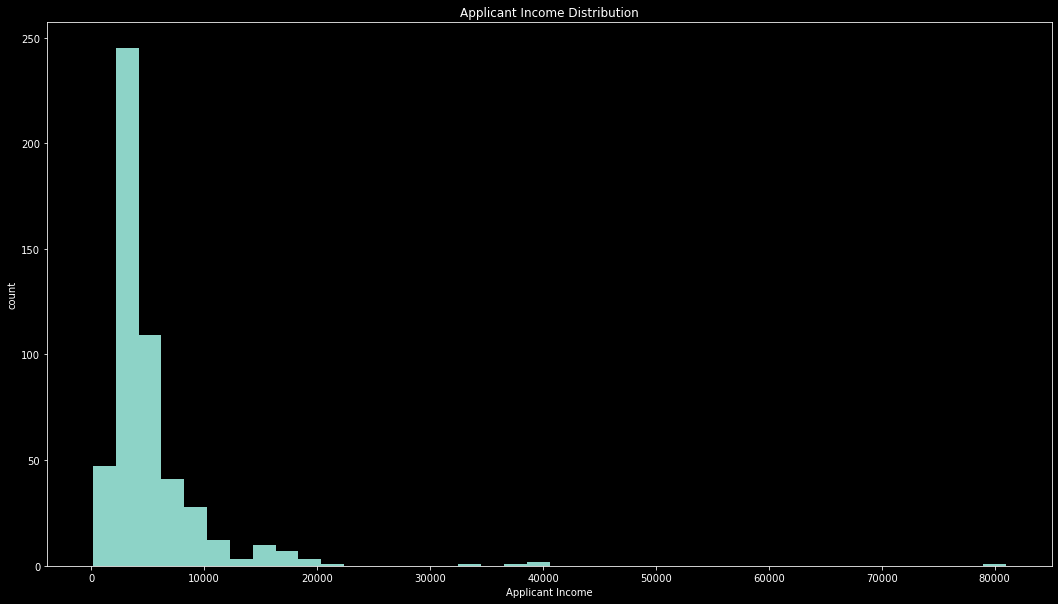

In [787]:
plt.figure(figsize=(18,10))
plt.title('Applicant Income Distribution')
plt.xlabel('Applicant Income')
plt.ylabel('count')
plt.hist(xnums['ApplicantIncome'], bins=40)

plt.show()

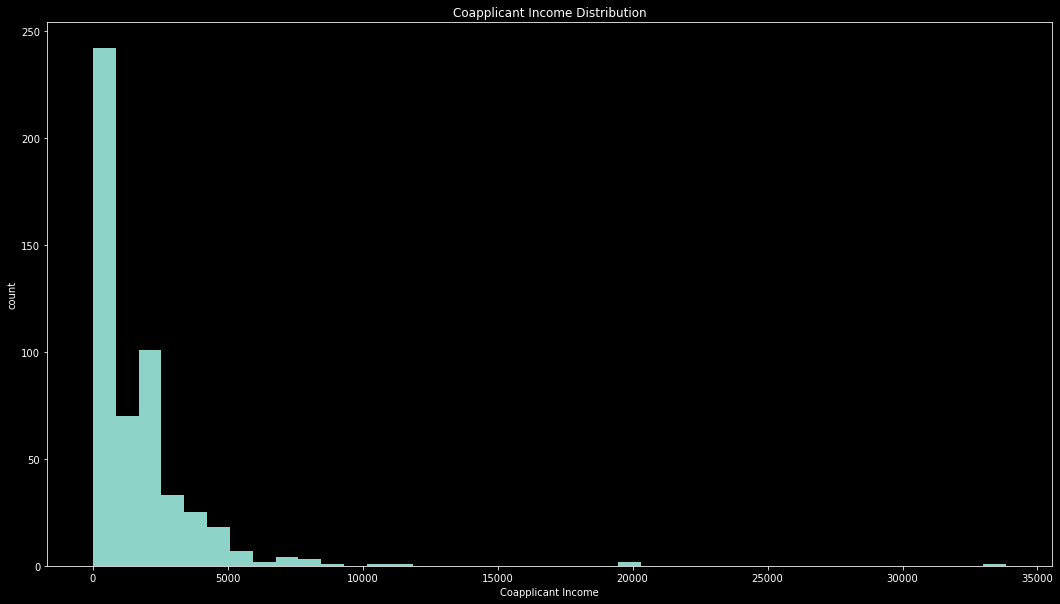

In [788]:
plt.figure(figsize=(18,10))
plt.title('Coapplicant Income Distribution')
plt.xlabel('Coapplicant Income')
plt.ylabel('count')
plt.hist(xnums['CoapplicantIncome'], bins=40)

plt.show()


Look at box plots to understand the distributions. 

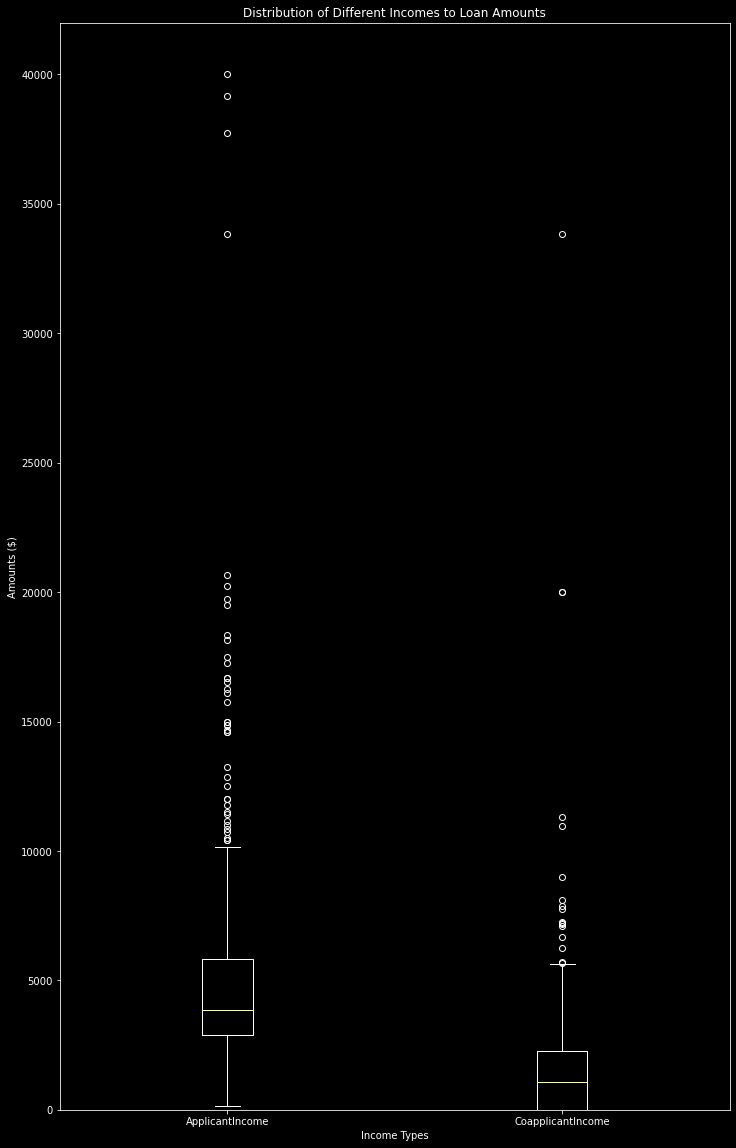

In [789]:
fig, ax = plt.subplots(figsize=(12,20))
ax.set_title('Distribution of Different Incomes to Loan Amounts')
ax.set_ylabel('Amounts ($)')
ax.set_xlabel('Income Types')
ax.set_ylim(0, 42000)
ax.boxplot(xnums[['ApplicantIncome', 'CoapplicantIncome']], labels=xnums.columns[:2])

plt.show()

Look at the distribution of income segregated  by `Education`

In [790]:
graduates = x[x['Education'] == 'Graduate']
notGraduates = x[x['Education'] == 'Not Graduate']

In [791]:
graduates['ApplicantIncome'].describe()

count      401.000000
mean      5723.516209
std       6092.577861
min        150.000000
25%       3029.000000
50%       4009.000000
75%       6250.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

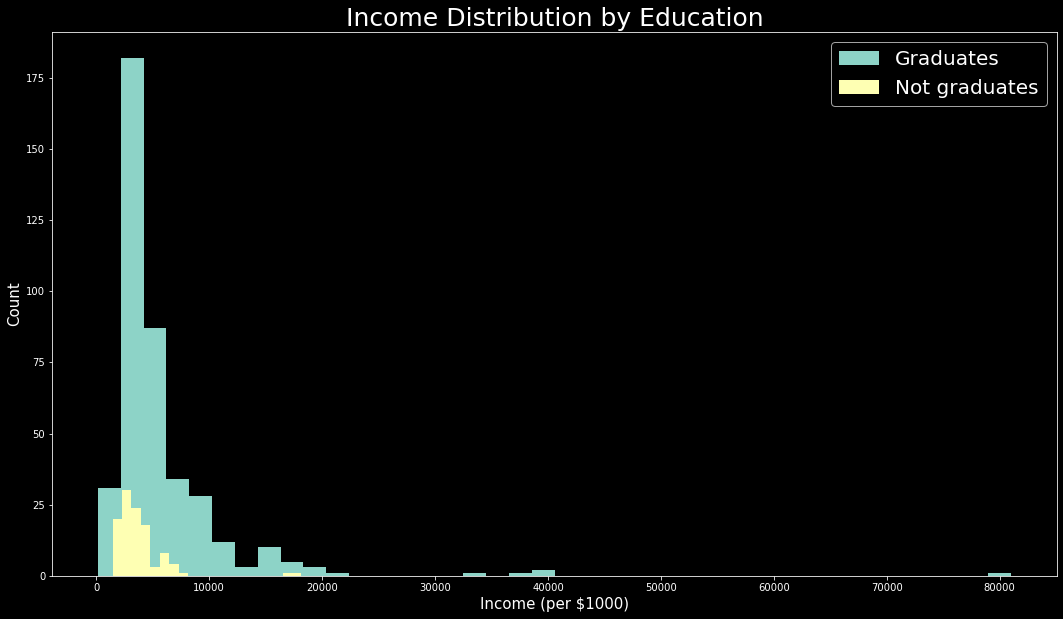

In [792]:
fig,ax = plt.subplots(figsize=(18,10))
ax.set_title('Income Distribution by Education', fontsize=25)
ax.set_xlabel('Income (per $1000)', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.hist(graduates['ApplicantIncome'], bins=40, label='Graduates')
ax.hist(notGraduates['ApplicantIncome'], bins=20, label='Not graduates')
ax.legend(fontsize=20)
plt.show()


Look at the histogram and boxplot of LoanAmount

(array([  9.,  33.,  67., 136.,  98.,  58.,  35.,  14.,  12.,  10.,   6.,
          2.,   2.,   1.,   1.,   2.,   3.,   0.,   1.,   2.]),
 array([  9.  ,  38.55,  68.1 ,  97.65, 127.2 , 156.75, 186.3 , 215.85,
        245.4 , 274.95, 304.5 , 334.05, 363.6 , 393.15, 422.7 , 452.25,
        481.8 , 511.35, 540.9 , 570.45, 600.  ]),
 <BarContainer object of 20 artists>)

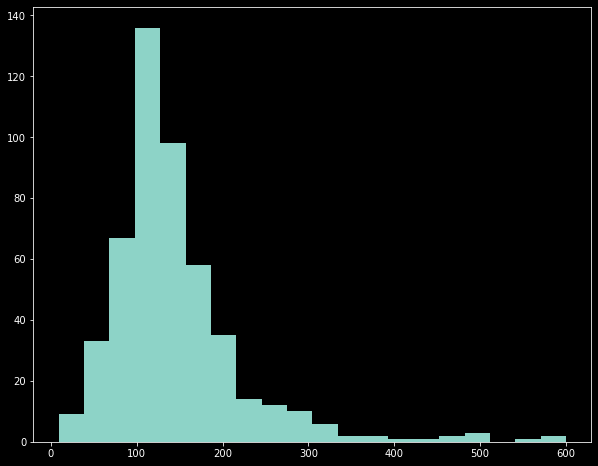

In [793]:
plt.figure(figsize=(10,8))
plt.hist(xnums['LoanAmount'], bins=20)

There might be some extreme values. Both `ApplicantIncome` and `LoanAmount` require some amount of data munging. `LoanAmount` has missing and well as extreme values values, while `ApplicantIncome` has a few extreme values, which demand deeper understanding. 

### Categorical variable analysis

Try to understand categorical variables in more details using `pandas.DataFrame.pivot_table` and some visualizations.

In [794]:
pd.pivot_table(x, values=['ApplicantIncome', 'CoapplicantIncome'], index=['Married', 'Education'])

ApplicantIncome  CoapplicantIncome
Married Education                                       
No      Graduate          5217.546099        1322.432624
        Not Graduate      4236.974359         710.589744
Yes     Graduate          5997.907692        1830.472769
        Not Graduate      3550.577465        1522.281690

## 3. Data Cleaning

This step typically involves imputing missing values and treating outliers. 

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.



Impute missing values for all columns. Use the values which you find most meaningful (mean, mode, median, zero.... maybe different mean values for different groups)

In [795]:
print(xcats.isnull().sum(),'\n')
print('0-term Loans:')
for col in xcats.columns:
      print(col, (xcats[col] == 0).sum()),

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
Property_Area        0
Loan_Amount_Term    12
Credit_History       0
dtype: int64 

0-term Loans:
Gender 0
Married 0
Dependents 0
Education 0
Self_Employed 0
Property_Area 0
Loan_Amount_Term 0
Credit_History 80


In [796]:
print(xnums.isnull().sum(),'\n')
for col in xnums.columns:
      print(col, (xnums[col] == 0).sum()),

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           19
dtype: int64 

ApplicantIncome 0
CoapplicantIncome 230
LoanAmount 0


In [797]:
zero_incomes = x[x['CoapplicantIncome'] == 0]

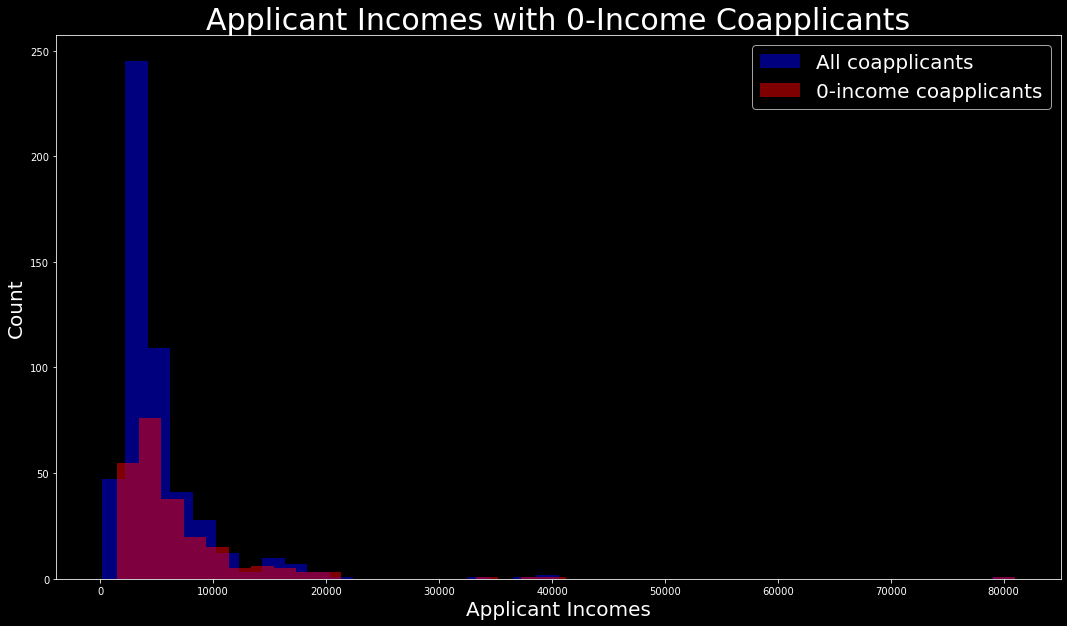

In [798]:
plt.subplots(figsize=(18,10))
plt.title('Applicant Incomes with 0-Income Coapplicants', fontsize=30)
plt.xlabel('Applicant Incomes', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.hist(xnums['ApplicantIncome'], bins=40, alpha=0.5, color='blue', label='All coapplicants')
plt.hist(zero_incomes['ApplicantIncome'], bins=40, alpha=0.5, color='red', label='0-income coapplicants')
plt.legend(fontsize=20)

plt.show()

In [799]:
cat_imp = SimpleImputer(strategy='most_frequent')
num_imp = SimpleImputer(strategy='mean')

xcats_imputed = cat_imp.fit_transform(xcats)
xnums_imputed = num_imp.fit_transform(xnums)

### Extreme values
Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

In [800]:
logged_loan = np.log(xnums['LoanAmount'])

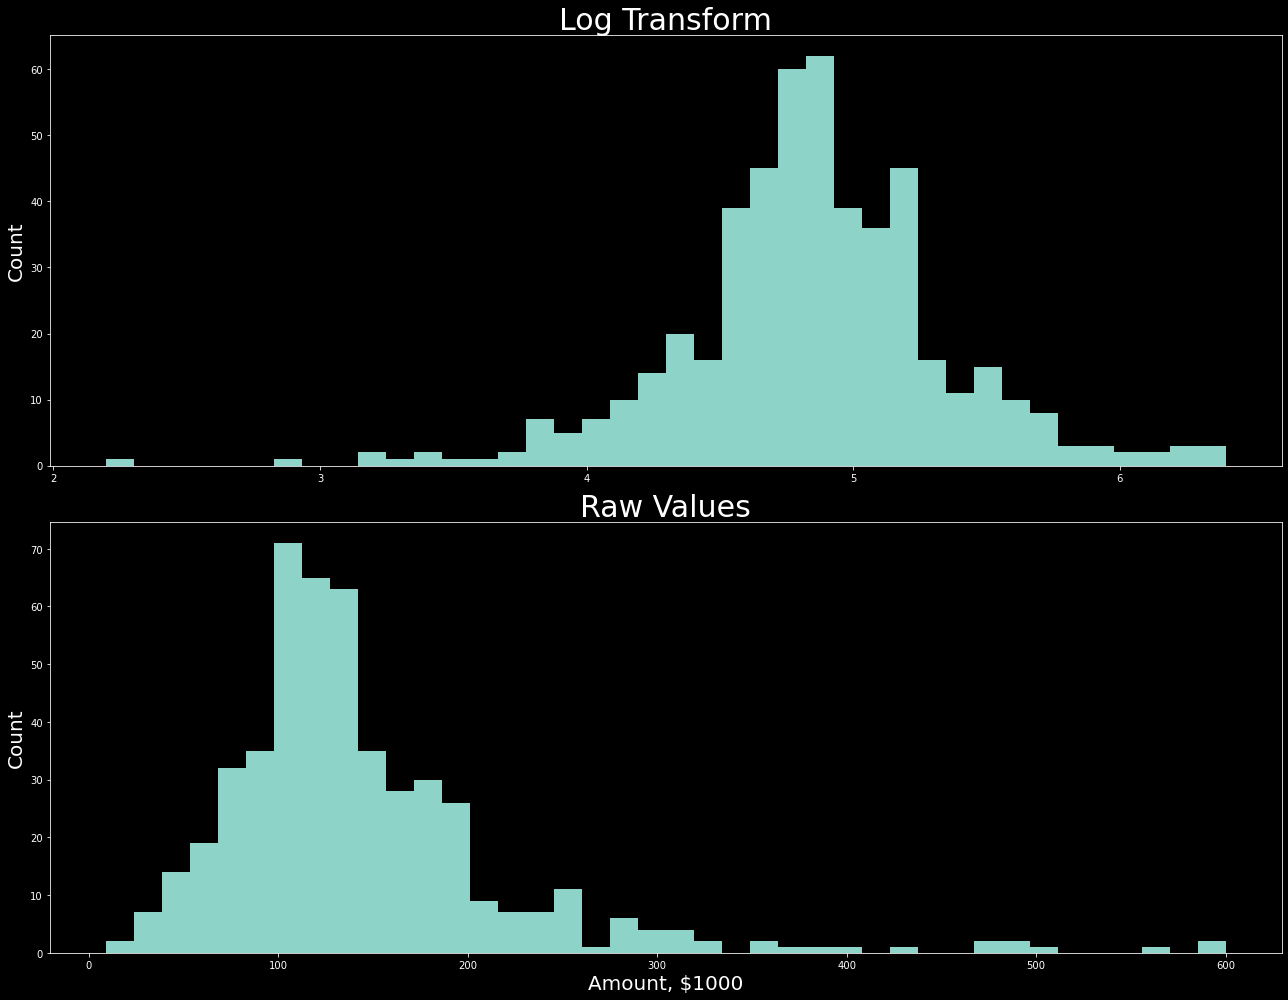

In [801]:
fig,ax = plt.subplots(nrows=2, figsize=(18,14))
ax[0].set_title('Log Transform', fontsize=30)
ax[0].set_ylabel('Count', fontsize=20)
# ax[0].set_xlabel('Amount, $1000', fontsize=20)
ax[0].hist(logged_loan, bins=40)
# ax[1].hist(xnums['LoanAmount'], bins=40)

ax[1].set_title('Raw Values', fontsize=30)
ax[1].set_ylabel('Count', fontsize=20)
ax[1].set_xlabel('Amount, $1000', fontsize=20)
# ax[1].hist(logged_loan, bins=40)
ax[1].hist(xnums['LoanAmount'], bins=40)

plt.tight_layout()
plt.show()

In [802]:
print(logged_loan.describe(), '\n')
print(xnums['LoanAmount'].describe())

count    492.000000
mean       4.846083
std        0.505802
min        2.197225
25%        4.605170
50%        4.852030
75%        5.135798
max        6.396930
Name: LoanAmount, dtype: float64 

count    492.000000
mean     144.136179
std       79.765056
min        9.000000
25%      100.000000
50%      128.000000
75%      170.000000
max      600.000000
Name: LoanAmount, dtype: float64


Combine both incomes as total income and take a log transformation of the same.

In [803]:
xnums['TotalIncome'] = xnums['ApplicantIncome'] + xnums['CoapplicantIncome']
logged_total = np.log(xnums['TotalIncome'])

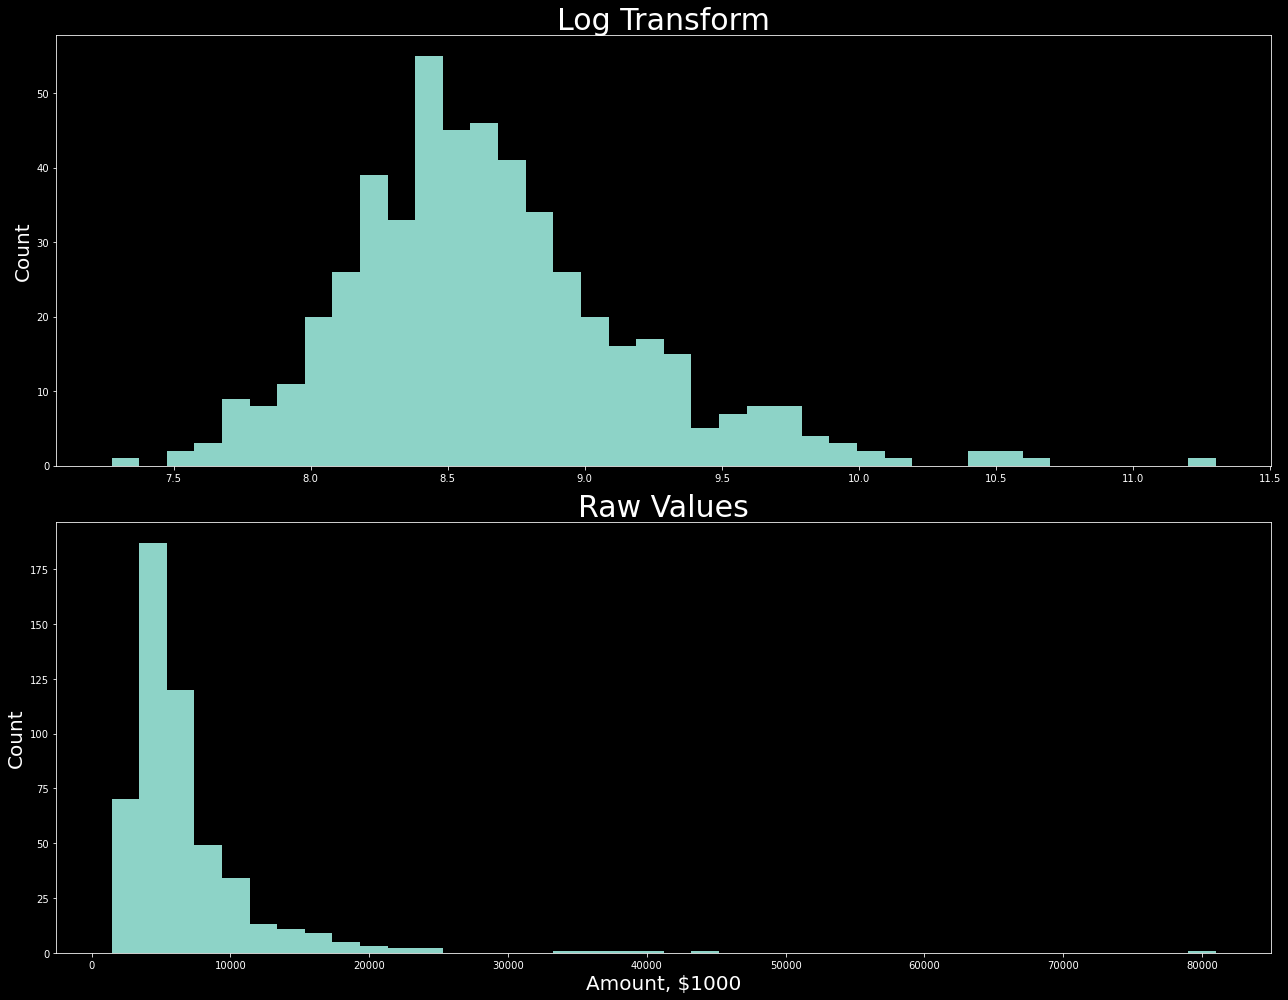

In [804]:
fig,ax = plt.subplots(nrows=2, figsize=(18,14))
ax[0].set_title('Log Transform', fontsize=30)
ax[0].set_ylabel('Count', fontsize=20)
ax[0].hist(logged_total, bins=40)

ax[1].set_title('Raw Values', fontsize=30)
ax[1].set_ylabel('Count', fontsize=20)
ax[1].set_xlabel('Amount, $1000', fontsize=20)
ax[1].hist(xnums['TotalIncome'], bins=40)

plt.tight_layout()
plt.show()

## 4. Building a Predictive Model

In [805]:
# modeling packages
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Try paramater grid search to improve the results

## 5. Using Pipeline
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

In [806]:
# preprocessing packages
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest

In [807]:
# pipeline packages
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

In [808]:
# using a FunctionTransformer to separate numerical values from categories
num_selection = FunctionTransformer(select_nums)
cat_selection = FunctionTransformer(select_cats)



In [809]:
# create training data
xtrain, xtest, ytrain, ytest = train_test_split(x, y)

## 6. Deploy your model to cloud and test it with PostMan, BASH or Python